# Milestone 1 Project: Mental Health Analysis in Teenagers

## Installation and Data Pre-processing

### Install kaggle hub

In [1]:
# Install kagglehub via shell command
!pip install kagglehub

### Install libraries

In [10]:
import pandas as pd
import numpy as np
import re
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns

# supress all warnings
import warnings
warnings.filterwarnings('ignore')

### Opening  the Format Program to read the SAS files

In [11]:
# Step 1: Define the full path to the .sas file inside your Google Drive
file_path = 'data/2023XXH-Formats-Program.sas'

# Step 2: Open the SAS file in read mode and read its contents
with open(file_path, 'r') as f:
    sas_code = f.read()

# Step 3: Print the first 1000 characters of the file to preview its content
print(sas_code[:1000])  # This helps you confirm you accessed the file correctly

/****************************************************************************************/
/*  This SAS program creates a permanent SAS format library that is used to analyze to  */
/*  analyze the 2023 YRBS dataset.                                                      */
/*                                                                                      */
/*  Change the file location specification from 'c:\YRBS2023' to the location where you */
/*  want the format library to be stored before you run this program.  Change the       */
/*  location specification in the 'library' statement at the top of the program.        */
/*                                                                                      */
/*  Note: Run '2023XXH Formats Program.sas' BEFORE you run                             */
/*  '2023XXH SAS Input Program.sas' to create the 2023 YRBS dataset.                   */
/****************************************************************************************/
l

### Read the SAS Input File

In [12]:
# Step 1: Read the SAS Input Program:
# the column position is denoted by the @ signs
# the variable or column name is denoted by Q
# the $ sign is a format SAS uses to say:
  # $ is a character(string)
  # 1. = width(1 character)

# Each row in the .dat file is a fixed-width text row, and this tells SAS how to:
  # Read each variable from a specific starting position
  # Name it (e.g. Q14, Q15, etc.)
  # Know how many characters to read (e.g. 1. means read 1 character)

with open('data/2023XXH-SAS-Input-Program.sas', 'r') as f:
    input_code = f.read()  # Read the entire contents of the SAS input program into a string

### Extracting the relevant columns using the SAS notation

Which columns do we need from the input file for our analysis ?
- We we use a list of strings to ahear to the SAS formatting
- This will allow us to extract the relevant information and pass that through to our pd.read_fwf function to turn into a Pandas dataframe.

In [13]:
# Step 2: Extract INPUT block lines
input_lines = input_code.splitlines()[:]  # this splits on the new line character in the string extracted above
# splitting here makes the input blocks readable and logical opposed to just print input_code above(without splitting)

### Regex helper function

In [14]:
def extract_width_from_format(format_spec):
    """
    Extracts the numeric field width from a SAS format specifier using regex.

    Parameters:
    format_spec : str
        The SAS format specifier string, such as "$8.", "4.2", or "F10.2".

    Returns:
    int
        The extracted width (e.g., 8 from "$8.") if a number is found,
        otherwise defaults to 1.

    Notes:
    This function uses regular expressions to find the first number in the format
    string, assuming it represents the field width in fixed-width file layouts.
    """
    # Use regex to search for the first sequence of digits in the string
    match = re.search(r'(\d+)', format_spec)

    # If a match is found, return it as an integer; otherwise, return 1
    return int(match.group(1)) if match else 1

### Main function to extract columns from SAS Program

In [15]:
def convert_sas_lines_to_colspecs(input_lines):
    """
    Converts SAS INPUT lines into fixed-width column specs and column names
    for use with pandas.read_fwf().

    Parameters:
    input_lines : list of str
        Each line corresponds to a SAS variable definition in the INPUT block,
        formatted with positions, variable names, and format specifiers.
        Example: "@21 GENDER $1."

    Returns:
    colspecs : list of tuple
        A list of (start, end) index tuples for fixed-width fields.
        These can be passed to pandas.read_fwf().

    column_names : list of str
        A list of corresponding variable names for each column spec.

    Notes:
    - SAS uses 1-based indexing, but Python uses 0-based indexing.
    - Only lines starting with '@' and containing at least two parts are considered valid.
    - Format widths are extracted using `extract_width_from_format()`.
    """
    colspecs = []       # To store (start, end) positions of each field
    column_names = []   # To store the variable names for each field

    for line in input_lines:
        # Clean and tokenize the line
        parts = line.strip().split()

        # Skip lines that don't follow the expected '@ position VAR format' structure
        if len(parts) < 2 or not parts[0].startswith('@'):
            continue

        # Convert SAS start position to Python 0-based index
        start = int(parts[0][1:]) - 1

        # Default width is 1 if no format specifier is given
        width = 1

        # Extract width from format if it exists
        if len(parts) > 2:
            width = extract_width_from_format(parts[2])

        # Calculate end position (exclusive)
        end = start + width

        # Store the column spec and name
        colspecs.append((start, end))
        column_names.append(parts[1])

    return colspecs, column_names

In [16]:
# use functions to get colspecs and column_names
colspecs, column_names = convert_sas_lines_to_colspecs(input_lines)

In [17]:
dat_path = 'data/XXH2023_YRBS_Data (1).dat'
df_cdc = pd.read_fwf(dat_path, colspecs=colspecs, names=column_names)

## Cleaning CDC Data

Notes:
Social Media Values Mapped to improve simplicity:

- `1` = **"Once a day or more"**  
- `0` = **"Less than once a day"**

In [18]:
def clean_yrbs_data(df):
    """Clean and transform YRBS CDC dataset."""

    # Rename Q2 to Sex and map values
    df = df.rename(columns={'Q2': 'sex'})
    df['sex'] = df['sex'].map({1: 'F', 2: 'M'})

    # Map Q1 to actual age and filter for age 13-17
    age_map = {
        1.0: 12,
        2.0: 13,
        3.0: 14,
        4.0: 15,
        5.0: 16,
        6.0: 17,
        7.0: 18
    }
    df['Q1'] = df['Q1'].map(age_map)
    df = df[df['Q1'].between(13, 17)]
    df = df.rename(columns={'Q1': 'age'})
    df['age'] = df['age'].astype(int)

    # Rename and round and map Q85 (sleep hours)
    if 'Q85' in df.columns:
      df = df.rename(columns={'Q85': 'sleep_hours'})
      sleep_map = {
        1: 4, 2: 5, 3: 6,
        4: 7, 5: 8, 6: 9,
        7: 10
    }
    df['sleep_hours'] = df['sleep_hours'].map(sleep_map).astype('Int64')

    # Rename and map Q26 (mental suffering)
    if 'Q26' in df.columns:
        df = df.rename(columns={'Q26': 'mental_suffering'})
        df['mental_suffering'] = df['mental_suffering'].map({1: 1, 2: 0})

    # Rename and map Q80 (social media usage)
    if 'Q80' in df.columns:
        df = df.rename(columns={'Q80': 'social_media_daily'})
        df['social_media_daily'] = df['social_media_daily'].map(
            lambda x: 1 if x in [5, 6, 7, 8] else (0 if x in [1, 2, 3, 4] else None)
        )

    return df

df_cdc = clean_yrbs_data(df_cdc)
df_cdc.head()

,age,sex,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,QNILLICT,QNOBESE,QNOWT,WEIGHT,STRATUM,PSU,BMIPCT,RACEETH,Q6ORIG,Q7ORIG
0,14,F,1.0,NaN,C,1.65,81.65,4.0,4.0,1.0,...,NaN,1.0,2.0,0.8614,103,16294,97.08,NaN,505,180
1,15,M,1.0,2.0,E,NaN,NaN,5.0,1.0,1.0,...,2.0,NaN,NaN,0.8920,103,16294,.,5.0,N N,233
2,16,M,3.0,2.0,E,1.68,74.84,5.0,3.0,2.0,...,1.0,2.0,1.0,0.5081,103,16294,92.26,5.0,506,165
3,17,F,2.0,2.0,E,NaN,NaN,4.0,1.0,2.0,...,1.0,NaN,NaN,1.1759,103,16294,.,5.0,N N,105
4,14,M,1.0,2.0,E,1.85,56.70,5.0,1.0,1.0,...,2.0,2.0,2.0,0.8920,103,16294,7.57,5.0,601,125


In [19]:
# Created a separate dataframe to include only the columns in use for the CDC dataset
used_cols = ['age', 'sex', 'sleep_hours', 'mental_suffering', 'social_media_daily']
df_cdc_cleaned = df_cdc[used_cols]
df_cdc_cleaned.head()

,age,sex,sleep_hours,mental_suffering,social_media_daily
0,14,F,6,1.0,1.0
1,15,M,8,0.0,0.0
2,16,M,4,1.0,1.0
3,17,F,7,1.0,1.0
4,14,M,6,1.0,1.0


In [20]:
def drop_nans_and_report(df):
    original_count = len(df)
    df_cleaned = df.dropna()
    cleaned_count = len(df_cleaned)
    dropped_count = original_count - cleaned_count

    print(f"Original rows: {original_count}")
    print(f"Rows after dropping NaNs: {cleaned_count}")
    print(f"Total rows dropped: {dropped_count}")

    return df_cleaned

In [21]:
df_cdc_cleaned = drop_nans_and_report(df_cdc_cleaned)

Original rows: 17794
Rows after dropping NaNs: 11867
Total rows dropped: 5927


In [22]:
df_cdc_cleaned['sleep_hours'].unique()

<IntegerArray>
[6, 8, 4, 7, 5, 10, 9]
Length: 7, dtype: Int64

In [23]:
unique_sleep_by_age = df_cdc_cleaned.groupby('age')['sleep_hours'].unique()
print(unique_sleep_by_age)


age
13              [8, 7, 6, 4]
14    [6, 5, 8, 7, 4, 9, 10]
15    [8, 4, 7, 6, 9, 10, 5]
16    [4, 5, 10, 8, 6, 7, 9]
17    [7, 5, 8, 6, 4, 10, 9]
Name: sleep_hours, dtype: object


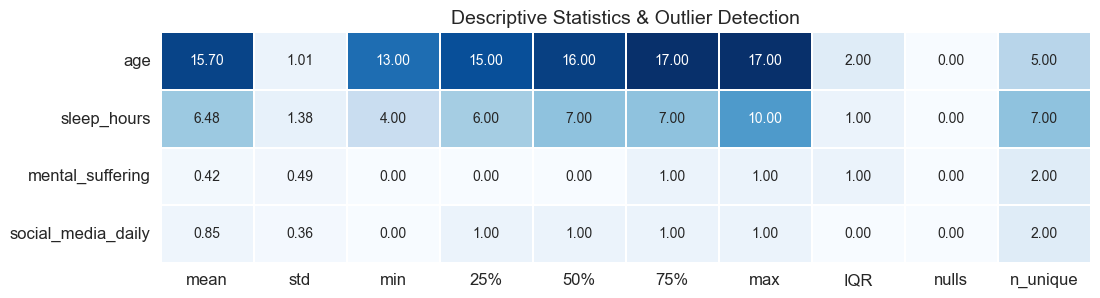

In [24]:
# implement the find_out function so that we are able to inspect the cleaned dataframe for any irregular occurances:

def find_out(dataframe):
    # Ensure only numeric columns are used for stats
    numeric_df = dataframe.select_dtypes(include=[float, int])

    # Compute descriptive stats
    desc = numeric_df.describe().T

    # Calculate IQR
    desc['IQR'] = desc['75%'] - desc['25%']

    # Add null count and unique count
    desc['nulls'] = numeric_df.isnull().sum()
    desc['n_unique'] = numeric_df.nunique()

    # Detect outliers
    desc['max_outlier'] = desc['max'] > (desc['75%'] + 1.5 * desc['IQR'])
    desc['min_outlier'] = desc['min'] < (desc['25%'] - 1.5 * desc['IQR'])

    # Select columns for heatmap
    out_df = desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR', 'nulls', 'n_unique']]
    # Clean up: drop rows where all stats are NaN (or fill if preferred)
    out_df = out_df.dropna(how='all')  # Drop rows with all NaNs
    out_df = out_df.astype(float)

    # Plot heatmap
    f, ax = plt.subplots(figsize=(12, out_df.shape[0] * 0.75))
    sns.heatmap(out_df,
                annot=True,
                cmap="Blues",
                fmt=".2f",
                ax=ax,
                linecolor="white",
                linewidths=1.1,
                cbar=False,
                annot_kws={"size": 10})

    plt.xticks(size=12)
    plt.yticks(size=12, rotation=0)
    plt.title("Descriptive Statistics & Outlier Detection", size=14)
    plt.show()

# only include the numerical datatypes

find_out(df_cdc_cleaned)

## Kaggle Dataset Manipulation:

In [25]:
# Importing the Kaggle Dataset:
mental_path = kagglehub.dataset_download('aniruddhawankhede/mental-heath-analysis-among-teenagers')

100%|██████████| 173k/173k [00:00<00:00, 2.21MB/s]

Extracting files...


In [26]:
# append the file name to the path using f-strings or simple concatenation
csv_path = f"{mental_path}/mental_health_analysis.csv"

# Read the CSV file
df_mental = pd.read_csv(csv_path)

In [27]:
df_mental.head()

,User_ID,Age,Gender,Social_Media_Hours,Exercise_Hours,Sleep_Hours,Screen_Time_Hours,Survey_Stress_Score,Wearable_Stress_Score,Support_System,Academic_Performance
0,1,16,F,9.654486,2.458001,5.198926,8.158189,3,0.288962,Moderate,Excellent
1,2,17,M,9.158143,0.392095,8.866097,5.151993,5,0.409446,Moderate,Good
2,3,15,M,5.028755,0.520119,4.943095,9.209325,2,0.423837,Moderate,Poor
3,4,17,F,7.951103,1.022630,5.262773,9.823658,5,0.666021,Moderate,Average
4,5,17,F,1.357459,1.225462,6.196080,11.338990,5,0.928060,High,Poor


In [28]:
# Clean and standardize the Kaggle mental health dataset

# Rename columns to standardize naming
#.str.strip()         # Removes any leading or trailing whitespace
#.str.lower()         # Converts all column names to lowercase
#.str.replace(" ", "_")  # Replaces all spaces with underscores

def clean_mental_health_data(df):
    """
    Cleans and standardizes the Kaggle mental health dataset.

    Steps:
    - Standardizes all column names to snake_case
    - Renames 'gender' column to 'sex' for consistency
    """
    # Step 1: Standardize column names to snake_case
    df.columns = (
        df.columns
        .str.strip()               # Remove leading/trailing whitespace
        .str.lower()               # Convert to lowercase
        .str.replace(" ", "_")     # Replace spaces with underscores
    )

    # Step 2: Rename 'gender' to 'sex' if present
    if 'gender' in df.columns:
        df.rename(columns={'gender': 'sex'}, inplace=True)

    return df

In [29]:


def filter_and_clean_behavioral_data(df):
    """
    Applies behavioral sanity checks and filters to the mental health dataset.

    Steps:
    - Filters out rows where screen_time < social_media_time
    - Ensures all time-related values (screen, sleep, exercise) are ≤ 24
    - Drops rows with missing sleep_hours or survey_stress_score
    - Filters age group to 13–17
    - Drops duplicate rows
    - Rounds sleep_hours to nearest integer (nullable Int64)
    """

    # Step 1: Filter for realistic behavioral values
    if {'screen_time_hours', 'social_media_hours'}.issubset(df.columns):
        df = df[df["screen_time_hours"] >= df["social_media_hours"]]

    if {'screen_time_hours', 'sleep_hours', 'exercise_hours'}.issubset(df.columns):
        df = df[df[['screen_time_hours', 'sleep_hours', 'exercise_hours']].le(24).all(axis=1)]

    # Step 2: Drop rows with missing key data
    df.dropna(subset=['sleep_hours', 'survey_stress_score'], inplace=True)

    # Step 3: Filter for target age group (13–17 years old)
    if 'age' in df.columns:
        df = df[df['age'].between(13, 17)]

    # Step 4: Remove duplicates
    df.drop_duplicates(inplace=True)

    # Step 5: Round sleep_hours to nearest integer
    if 'sleep_hours' in df.columns:
        df['sleep_hours'] = df['sleep_hours'].round(0).astype('Int64')

    return df



In [30]:
# Step 1: Standardize column names and rename 'gender' to 'sex'
df_mental = clean_mental_health_data(df_mental)

# Step 2: Apply sanity filters and behavioral cleaning
df_mental = filter_and_clean_behavioral_data(df_mental)

In [31]:
df_mental.head()

,user_id,age,sex,social_media_hours,exercise_hours,sleep_hours,screen_time_hours,survey_stress_score,wearable_stress_score,support_system,academic_performance
2,3,15,M,5.028755,0.520119,5,9.209325,2,0.423837,Moderate,Poor
3,4,17,F,7.951103,1.022630,5,9.823658,5,0.666021,Moderate,Average
4,5,17,F,1.357459,1.225462,6,11.338990,5,0.928060,High,Poor
7,8,15,F,1.637290,0.290854,5,8.026163,4,0.910201,Moderate,Poor
8,9,15,M,2.994231,1.053651,7,7.252061,5,0.117732,Low,Poor


### Use the find out function to analyse cleaned mental health dataset for potential outliers or cleaning errors

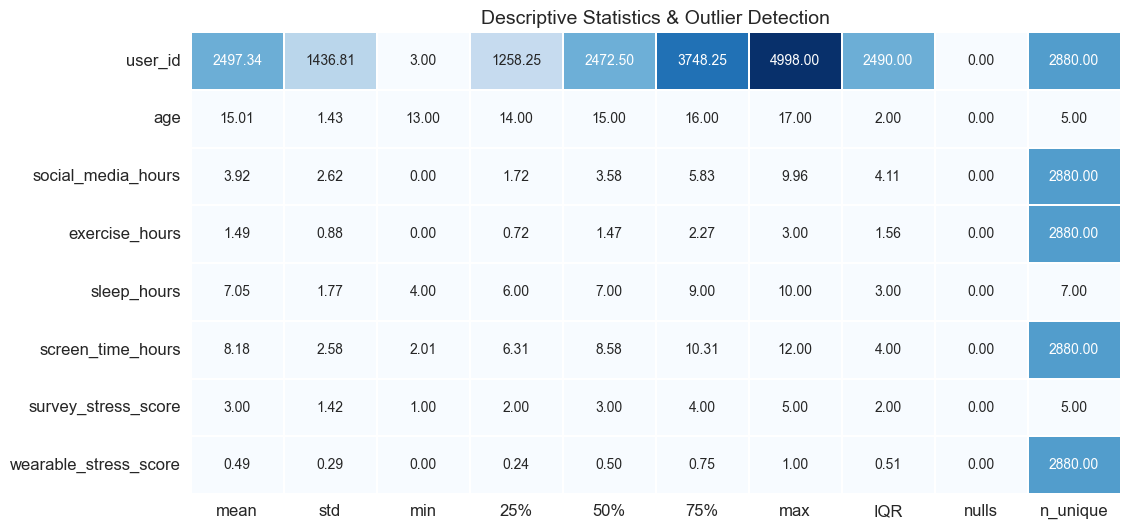

In [32]:
find_out(df_mental)

## Feature enginneering

### CDC Dataset Features:

- grouby age, sex and sleep hours
- agg mental suffering reports for each unique group

In [33]:
def summarize_cdc_data(df):
    """
    Groups and summarizes the CDC dataset by age, sex, and sleep_hours.

    Returns:
    - Count of students reporting mental suffering
    - Count of students using social media ≥ once a day
    """
    summary = (
        df.groupby(['age', 'sex', 'sleep_hours'], as_index=False)
          .agg(
              mental_suffering_count=('mental_suffering', 'sum'),
              social_media_daily_count=('social_media_daily', 'sum')
          )
    )
    return summary

### Mental Dataset Features:

- grouby age, sex and sleep hours
- agg relevant variables for each unique group

In [34]:
def summarize_mental_health_data(df):
    """
    Groups and summarizes the Kaggle mental health dataset by age, sex, and sleep_hours.

    Returns:
    - Average values of exercise hours, social media hours, screen time hours, and wearable stress score
    """
    summary = (
        df.groupby(['age', 'sex', 'sleep_hours'], as_index=False)
          .agg(
              avg_exercise_hours     =('exercise_hours',     'mean'),
              avg_social_media_hours =('social_media_hours', 'mean'),
              avg_screen_time_hours  =('screen_time_hours',  'mean'),
              avg_stress_score       =('wearable_stress_score', 'mean')
          )
    )
    return summary

In [35]:
# Applying the summary functions to the relevant datasets to create features

# notice here that we passed in df_cdc_cleaned and not df_cdc

cdc_summary = summarize_cdc_data(df_cdc_cleaned)
mental_summary = summarize_mental_health_data(df_mental)

### Merge preparation

In [36]:
def merge_and_clean_summaries(mental_summary, cdc_summary):
    """
    - Rounds numeric averages in mental_summary to 2 decimal places.
    - Merges mental_summary with cdc_summary on age, sex, and sleep_hours.
    - Replaces NaNs in count columns with 0 and converts them to integers.

    Returns:
    - Merged and cleaned dataframe.
    """

    # Step 1: Round average metrics to 2 decimal places
    cols_to_round = [
        'avg_exercise_hours',
        'avg_social_media_hours',
        'avg_screen_time_hours',
        'avg_stress_score'
    ]
    mental_summary[cols_to_round] = mental_summary[cols_to_round].round(2)

    # Step 2: Merge on age, sex, sleep_hours
    merged = pd.merge(
        mental_summary,
        cdc_summary,
        on=['age', 'sex', 'sleep_hours'],
        how='inner'
    )

    return merged

In [37]:
def drop_nans_and_report(df):
  """
  This function checks how many rows are in the merged dataframe and then dropps any rows with NaN values.
  It also reports the dropped values and shape difference before and after the drop
  """
  original_count = len(df)
  df_cleaned = df.dropna()
  cleaned_count = len(df_cleaned)
  dropped_count = original_count - cleaned_count

  print(f"Original rows: {original_count}")
  print(f"Rows after dropping NaNs: {cleaned_count}")
  print(f"Total rows dropped: {dropped_count}")

  return df_cleaned


### Merge Dataframe

In [38]:
merged = merge_and_clean_summaries(mental_summary, cdc_summary)

### Ensure NaN values are dropped

This function checks how many rows are in the merged dataframe and then dropps any rows with NaN values. It also reports the dropped values and shape difference before and after the drop

In [39]:
merged = drop_nans_and_report(merged)

Original rows: 63
Rows after dropping NaNs: 63
Total rows dropped: 0


In [40]:
merged.head()

,age,sex,sleep_hours,avg_exercise_hours,avg_social_media_hours,avg_screen_time_hours,avg_stress_score,mental_suffering_count,social_media_daily_count
0,13,F,4,1.74,4.80,8.41,0.42,0.0,1.0
1,13,F,6,1.35,4.06,7.74,0.40,0.0,0.0
2,13,F,7,1.51,3.52,7.18,0.45,1.0,2.0
3,13,F,8,1.68,3.92,8.06,0.53,0.0,1.0
4,13,M,6,1.39,3.47,6.82,0.51,1.0,0.0


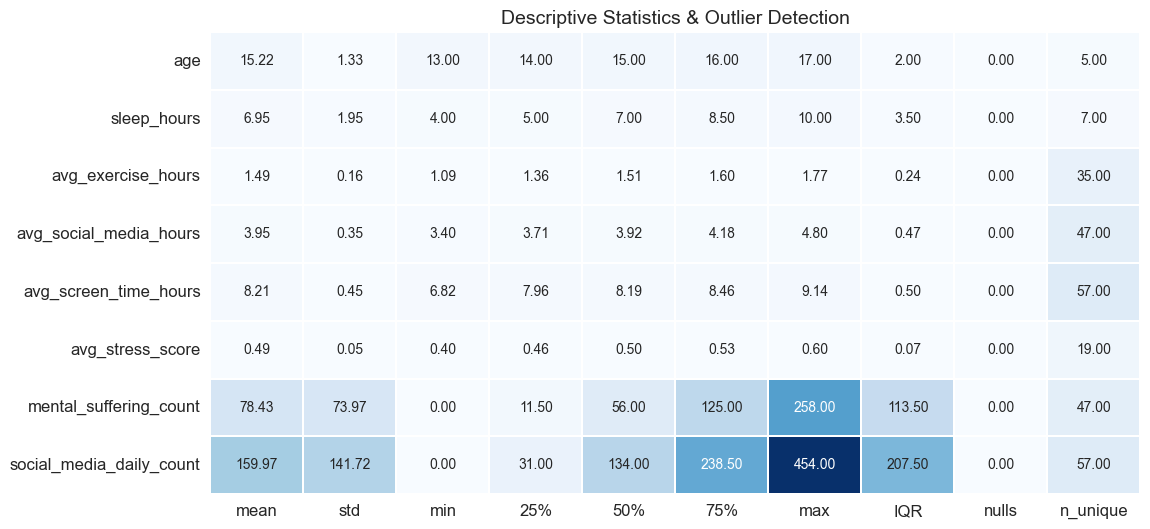

In [41]:
# implementing the find_out function to check for any outliers or null values in the merged dataframe:

find_out(merged)

### Exploratory Insights

To ensure we aren't making any errors in how we’ve grouped by age and sex, let's create a bar graph to check the underlying distribution.

Text(0, 0.5, 'Count')

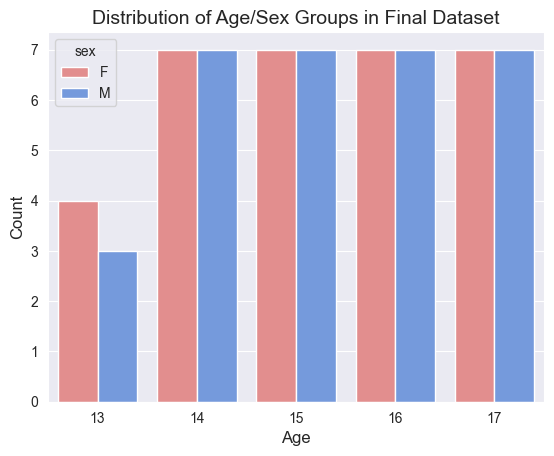

In [42]:
# Make a custom palette with gendered colors
pal = dict(M="#6495ED", F="#F08080")
# Plot
ax = sns.countplot(data=merged, x='age', hue='sex', palette=pal)
# Title/Labels
plt.title("Distribution of Age/Sex Groups in Final Dataset", fontsize=14)
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

## Visualizations



### Heatmap

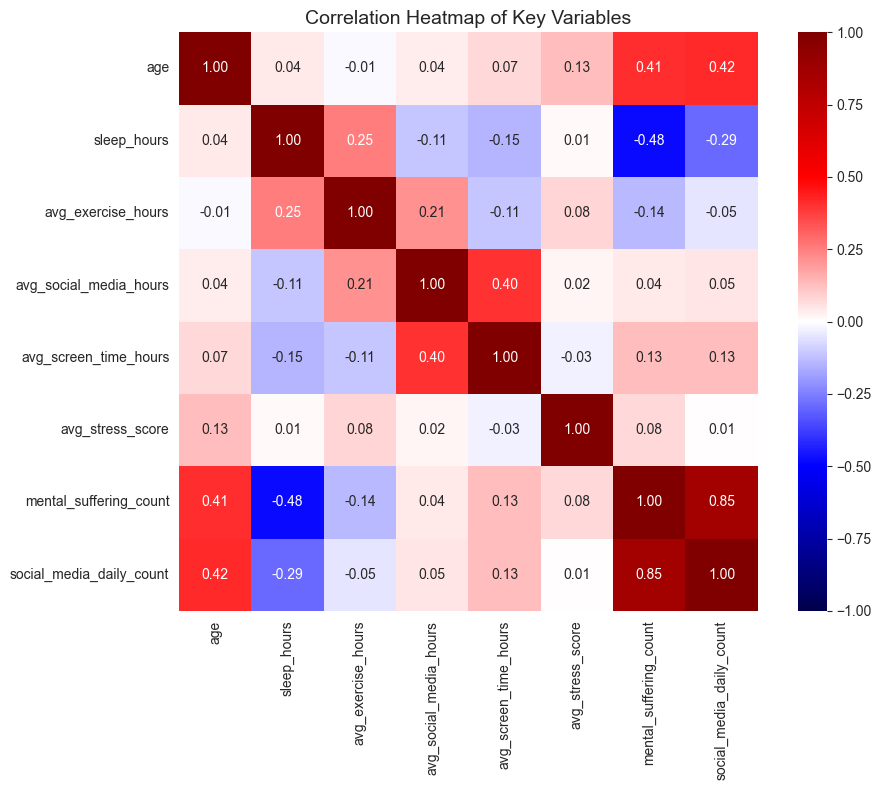

In [43]:

# Filter to include only numerical columns
numeric_df = merged.select_dtypes(include='number')

# Compute the correlation matrix
corr = numeric_df.corr()

# Set up the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",         # format numbers
    cmap='seismic',   # color scheme
    vmin=-1, vmax=1,   # set scale from -1 to 1
    square=True
)

plt.title("Correlation Heatmap of Key Variables", fontsize=14)
plt.tight_layout()
plt.show()

### Create a more optimise heatmap with key variables

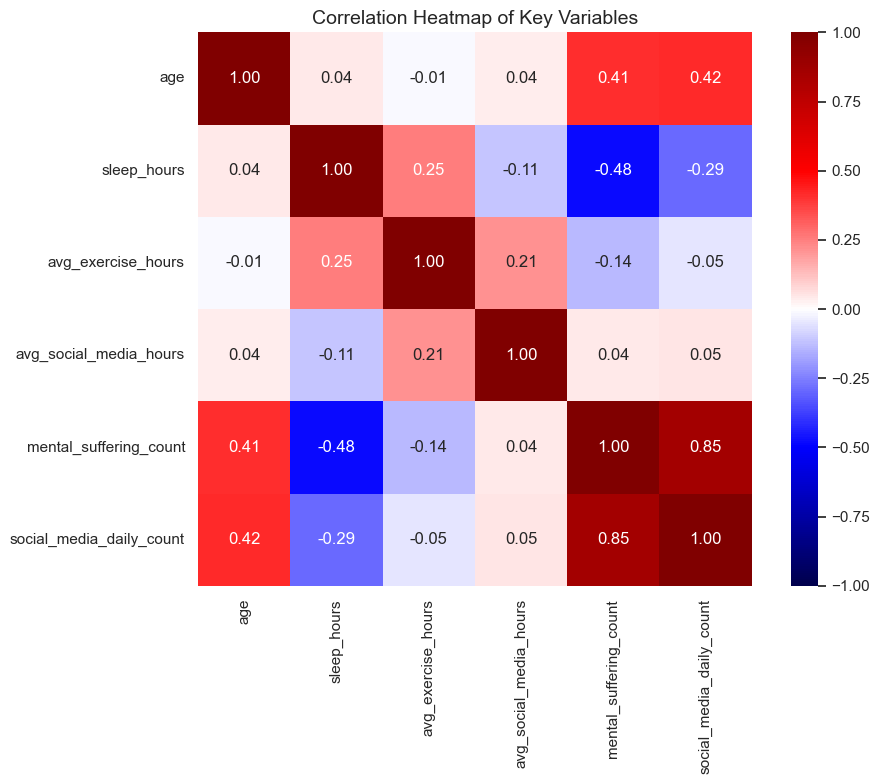

In [44]:
# Set theme
sns.set_theme(style="darkgrid")

# Filter to include only numerical columns
numeric_df = merged.select_dtypes(include='number')

# Drop variables that are not useful for the correlation analysis
updated_heat_df = numeric_df.drop(columns=['avg_screen_time_hours', 'avg_stress_score'])

# Compute the correlation matrix
corr = updated_heat_df.corr()

# Set up the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,         # Show correlation values
    fmt=".2f",          # Format numbers
    cmap='seismic',    # Color scheme for deep contrast
    vmin=-1, vmax=1,    # Scale from -1 to 1
    square=True
)

plt.title("Correlation Heatmap of Key Variables", fontsize=14)
plt.tight_layout()
plt.show()

Interesting notes from the Heatmap:
- **High positive correlation** between *social_media_daily_count* and *mental_suffering_count*
- **High negative correlation** between *Sleep_Hours* and *social_media_daily_count* & *mental_suffering_count*

Something that is also interesting to see is that *avg_exercise_hours* has a small protective effect against reports of mental suffering (-0.14)

### Plotting a sorted correlation bar char (just for mental suffer count)

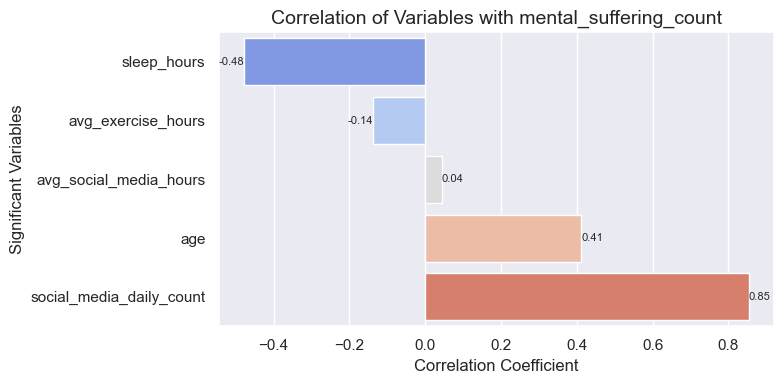

In [45]:
target = 'mental_suffering_count'

# Select the column of correlations and drops rows were the target variable correlates with itself.
correlations = corr[target].drop(target).sort_values()


plt.figure(figsize = (8,4))
ax = sns.barplot(
    x=correlations.values,
    y=correlations.index,
    hue=correlations.index,
    palette='coolwarm',
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=8)

plt.title(f"Correlation of Variables with {target}", fontsize = 14)

plt.xlabel("Correlation Coefficient")
plt.ylabel("Significant Variables")
plt.tight_layout()
plt.show()

This visualization shows the relationships of mental_suffering_count against our other variables. This very cleary communicates the Strong positive relationship with *social_media_daily_count* and negative relationship with *Sleep_Hours*

### How does social media use effect reports of mental suffering ?

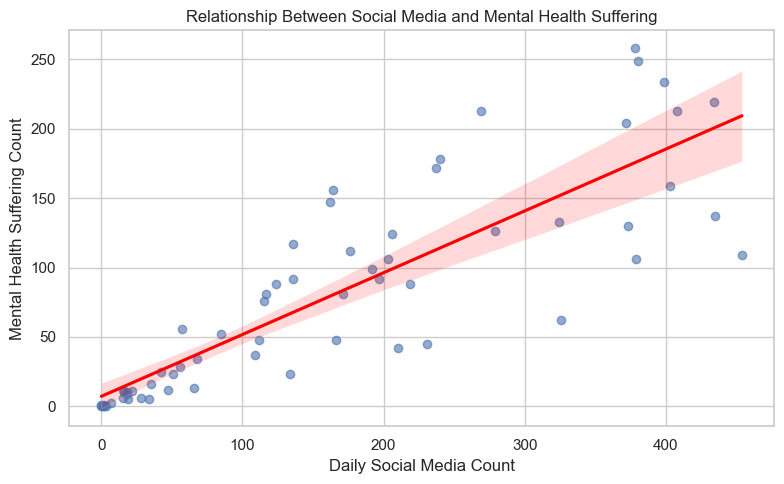

In [46]:
# Plotting regression between exercise hours and mental health struggles
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.regplot(
    data=merged,
    x="social_media_daily_count",
    y="mental_suffering_count",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"},
    ci=95
)
plt.title("Relationship Between Social Media and Mental Health Suffering")
plt.xlabel("Daily Social Media Count")
plt.ylabel("Mental Health Suffering Count")
plt.tight_layout()
plt.show()

With this seaborn regplot, we can see the dots which represent the grouping we made (Age (13-17) + Gender (F-M) + Sleep Hours (4-10)).
- We see a relationship between Social media and Mental health suffering: students that report high social media usage tend to report mental health suffering.

### Question: How does average sleep hours effect mental health suffering ?

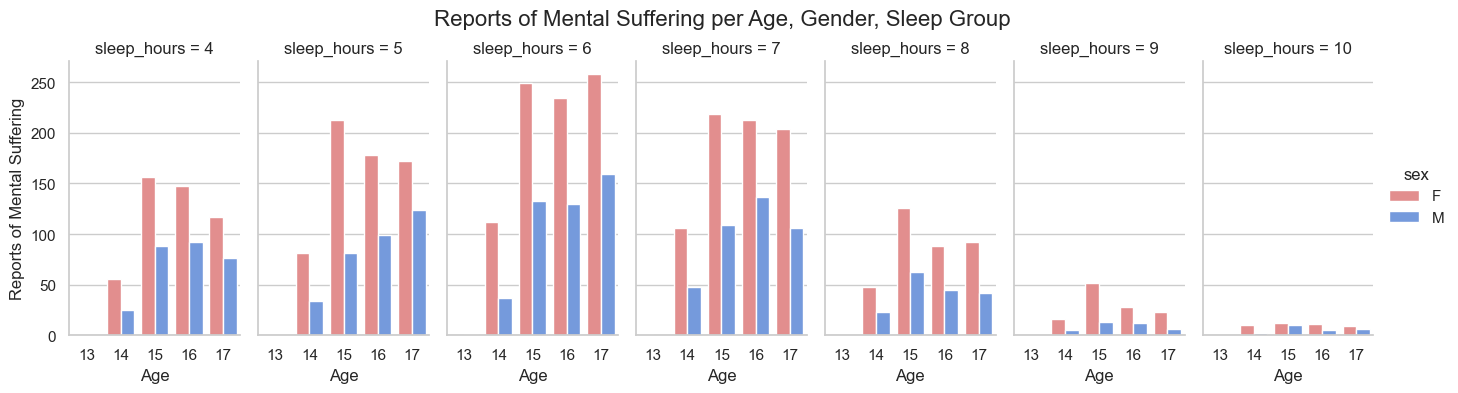

In [47]:
g = sns.catplot(
    data=merged,
    kind="bar",
    x="age",
    y="mental_suffering_count",
    hue="sex",
    col="sleep_hours",
    palette=pal,
    height=4,
    aspect=0.5,
)

# Set unified axis labels
g.set_axis_labels("Age", "Reports of Mental Suffering")

# Add a main title
g.fig.suptitle("Reports of Mental Suffering per Age, Gender, Sleep Group", fontsize=16)

# Adjust layout so title doesn't overlap
g.fig.subplots_adjust(top=0.85)

plt.show()

 This visualization shows a strong pattern: fewer sleep hours are associated with higher reported mental suffering, especially among adolescent girls.


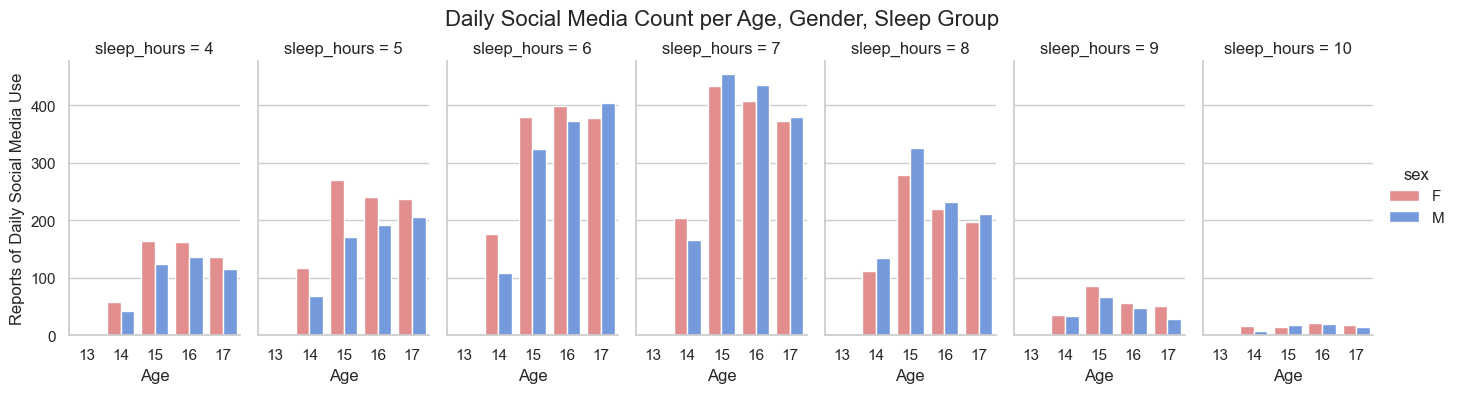

In [48]:
h = sns.catplot(
    merged, kind="bar",
    x="age", y="social_media_daily_count", hue="sex", col="sleep_hours", palette=pal,
    height=4, aspect=.5,
)

# Set unified axis labels
h.set_axis_labels("Age", "Reports of Daily Social Media Use")

# Add a main title above all subplots
h.fig.suptitle("Daily Social Media Count per Age, Gender, Sleep Group", fontsize=16)

# Adjust layout so title doesn't overlap
h.fig.subplots_adjust(top=0.85)

plt.show()



### What is the relationship between exercise hours and reports of mental suffering ?

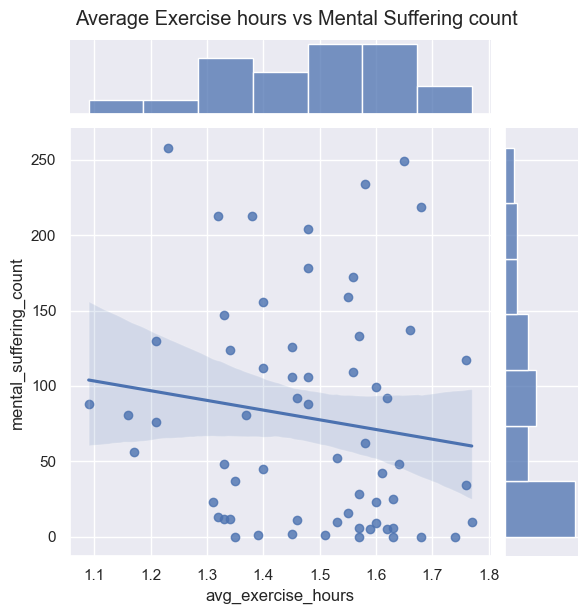

In [49]:
# Set theme
sns.set_theme(style="darkgrid")
# Make JoinGrid to see Avg Exercise vs Mental Suffering Count
g = sns.JointGrid(data=merged, x="avg_exercise_hours", y="mental_suffering_count")
plt.suptitle('Average Exercise hours vs Mental Suffering count', y=1.02)
g.plot(sns.regplot, sns.histplot)

### Does more exercise hours correlate with less social media usage ?


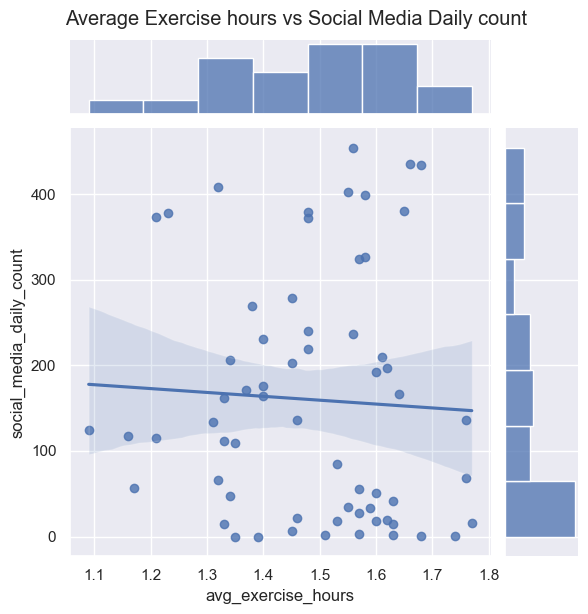

In [50]:
# Set theme
sns.set_theme(style="darkgrid")
# Make JoinGrid to see Avg Exercise vs Social Media daily
g = sns.JointGrid(data=merged, x="avg_exercise_hours", y="social_media_daily_count")
plt.suptitle('Average Exercise hours vs Social Media Daily count', y=1.02)
g.plot(sns.regplot, sns.histplot)